In [1]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F
import wandb
import os
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import math
import torch

In [36]:
# Definir la arquitectura de la CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #Canales de entrada, Canales de salida, Tamaño de Kernel, Stride y Padding
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 2)
        self.conv2 = nn.Conv2d(16, 64, 3, 1, 1) 
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 64 * 64, 512) 
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 3)

    def forward(self, x):
        #Entrada (batch, channels, ancho, largo)
        # (64, 3, 32, 32)
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2, 2) # No es una capa aprendible. (feature_maps, stride, padding)
        # (64, 16, 16, 16)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        # (64, 64, 8, 8)
        x = torch.relu(self.conv3(x))
        x = self.dropout(x)
        x = torch.max_pool2d(x, 2, 2)
        # (64, 128, 4, 4)
        x = x.view(-1, 128 * 64 * 64)
        # (64, 2048)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Definir la arquitectura de la CNN 1 convoluciones y 1 redes fc 
# Definir la arquitectura de la CNN
class CNNSimpleUno(nn.Module):
    def __init__(self):
        super(CNNSimpleUno, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 3,1,2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, 3)

    def forward(self, x):

        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 8, 8)

        x = self.dropout(x)

        x = x.view(-1, 128 * 64  * 64 )
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    # Definir la arquitectura de la CNN 2 convoluciones y 2 redes fc 
class CNNSimpleDos(nn.Module):
    def __init__(self):
        super(CNNSimpleDos, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3,1,2)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1) 

        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 3)

    def forward(self, x):

        x = torch.relu(self.conv1(x))

        x = torch.max_pool2d(x, 4, 4)
       

        x = torch.relu(self.conv2(x))
        x = self.dropout(x)
        x = torch.max_pool2d(x, 2, 2)
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
  

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Is Torch Cuda Available? " + str(torch.cuda.is_available()))

Is Torch Cuda Available? True


In [4]:
def train(network,  criterion, optimizer, trainloader):
    network.train() # Se asigna el the modelo a train mode
    running_loss = 0.0
    #correctos y torales para el acurracy
    correct = 0
    total = 0
    # Entrenamiento del modelo
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = network(inputs)
        # Se calcula el loss actual 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
         #Para el accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        
        correct += predicted.eq(labels).sum().item()
    accuracy = 100 * correct / total
    return running_loss / len(trainloader), accuracy

def validate(network,  criterion, testloader):
    network.eval()  # Se asigna el the modelo a evaluation mode
    total_loss = 0.0
    #correctos y torales para el acurracy
    correct = 0
    total = 0
    # Y correctos y la Y predicion matrix de confusion
    y_true = []
    y_pred = []
    # Testeo del modelo
    with torch.no_grad():  # Disable gradient computation during validation
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            # Se calcula el loss actual 
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            #Para el accuracy
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            #matrix de confusion
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(testloader)
    return avg_loss, accuracy,y_true,y_pred

In [11]:
# CNNSimpleDos con raw dataset
# directorio para leer los datos
data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/raw'

transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((256, 256)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset
# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)

# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNNSimpleDos().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")


start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "Confusion Matrix")},
                                                                commit=False)
    
   






wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epoch: 1  Train Loss: 0.5624  Train Acc: 75.4316  Valid Loss: 0.4120  Valid Acc: 83.0808
Epoch: 2  Train Loss: 0.2799  Train Acc: 89.6414  Valid Loss: 0.5542  Valid Acc: 79.0404
Epoch: 3  Train Loss: 0.2106  Train Acc: 91.4343  Valid Loss: 0.3750  Valid Acc: 87.8788
Epoch: 4  Train Loss: 0.1317  Train Acc: 94.2895  Valid Loss: 0.3790  Valid Acc: 83.8384
Epoch: 5  Train Loss: 0.0851  Train Acc: 96.8127  Valid Loss: 0.4699  Valid Acc: 82.8283
Epoch: 6  Train Loss: 0.0588  Train Acc: 98.0080  Valid Loss: 0.4386  Valid Acc: 86.3636
Epoch: 7  Train Loss: 0.0623  Train Acc: 97.8088  Valid Loss: 0.7791  Valid Acc: 83.3333
Epoch: 8  Train Loss: 0.0596  Train Acc: 98.1408  Valid Loss: 0.4370  Valid Acc: 87.3737
Epoch: 9  Train Loss: 0.0730  Train Acc: 99.0704  Valid Loss: 0.5620  Valid Acc: 88.3838
Epoch: 10  Train Loss: 0.1308  Train Acc: 94.6215  Valid Loss: 0.4055  Valid Acc: 87.1212


In [13]:
# CNNSimpleDos con cannyfilter dataset
# directorio para leer los datos
data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/cannyFilter'
transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((32, 32)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset
# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)
# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNNSimpleDos().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")


start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "Confusion Matrix")},
                                                                commit=False)
    
   

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Elapsed time:,▁▂▃▃▄▅▆▆▇█
Epoch,▁▂▃▃▄▅▆▆▇█
Train Acc,▁▅▆▇▇████▇
Train Loss,█▄▃▂▁▁▁▁▁▂
Valid Acc,▄▁█▅▄▆▄▇█▇
Valid Loss,▂▄▁▁▃▂█▂▄▂
Elapsed time:,885.06064
Epoch,10
Train Acc,94.62151
Train Loss,0.13076
Valid Acc,87.12121


Epoch: 1  Train Loss: 1.0475  Train Acc: 45.6839  Valid Loss: 1.1293  Valid Acc: 39.1414
Epoch: 2  Train Loss: 0.9496  Train Acc: 54.1833  Valid Loss: 1.0375  Valid Acc: 42.6768
Epoch: 3  Train Loss: 0.7572  Train Acc: 67.5299  Valid Loss: 0.9712  Valid Acc: 48.7374
Epoch: 4  Train Loss: 0.6082  Train Acc: 76.0956  Valid Loss: 0.8768  Valid Acc: 60.1010
Epoch: 5  Train Loss: 0.4898  Train Acc: 80.0797  Valid Loss: 1.0751  Valid Acc: 59.0909
Epoch: 6  Train Loss: 0.4701  Train Acc: 81.1421  Valid Loss: 0.8538  Valid Acc: 60.8586
Epoch: 7  Train Loss: 0.4113  Train Acc: 83.7317  Valid Loss: 0.8523  Valid Acc: 62.8788
Epoch: 8  Train Loss: 0.3685  Train Acc: 86.6534  Valid Loss: 0.8167  Valid Acc: 67.4242
Epoch: 9  Train Loss: 0.4046  Train Acc: 84.5950  Valid Loss: 1.0560  Valid Acc: 55.8081
Epoch: 10  Train Loss: 0.3355  Train Acc: 87.5166  Valid Loss: 0.9240  Valid Acc: 69.9495


In [16]:
# CNNSimpleDos con bilateralFilter dataset
# directorio para leer los datos
data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/bilateralFilter'
transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((32, 32)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset
# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)
# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNNSimpleDos().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")
start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "Confusion Matrix")},
                                                                commit=False)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Elapsed time:,▁▂▂▃▄▄▅▆▇█
Epoch,▁▂▃▃▄▅▆▆▇█
Train Acc,▁▂▅▆▇▇▇███
Train Loss,█▇▅▄▃▂▂▁▂▁
Valid Acc,▁▂▃▆▆▆▆▇▅█
Valid Loss,█▆▄▂▇▂▂▁▆▃
Elapsed time:,1017.93404
Epoch,10
Train Acc,87.5166
Train Loss,0.33553
Valid Acc,69.94949


Epoch: 1  Train Loss: 0.5071  Train Acc: 78.8181  Valid Loss: 0.6411  Valid Acc: 77.5253
Epoch: 2  Train Loss: 0.2728  Train Acc: 89.6414  Valid Loss: 0.4703  Valid Acc: 78.0303
Epoch: 3  Train Loss: 0.2348  Train Acc: 90.8367  Valid Loss: 0.5099  Valid Acc: 84.0909
Epoch: 4  Train Loss: 0.1548  Train Acc: 94.2895  Valid Loss: 0.4824  Valid Acc: 86.1111
Epoch: 5  Train Loss: 0.0972  Train Acc: 96.6799  Valid Loss: 0.6659  Valid Acc: 81.5657
Epoch: 6  Train Loss: 0.0862  Train Acc: 96.8127  Valid Loss: 0.4378  Valid Acc: 84.0909
Epoch: 7  Train Loss: 0.0587  Train Acc: 98.0080  Valid Loss: 0.4822  Valid Acc: 86.3636
Epoch: 8  Train Loss: 0.0693  Train Acc: 97.5432  Valid Loss: 0.5106  Valid Acc: 83.8384
Epoch: 9  Train Loss: 0.0450  Train Acc: 98.5392  Valid Loss: 0.5612  Valid Acc: 86.3636
Epoch: 10  Train Loss: 0.0304  Train Acc: 99.1368  Valid Loss: 0.6087  Valid Acc: 85.8586


In [39]:
# CNNSimpleDos con raw dataset
# directorio para leer los datos
data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/raw'
transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((512, 512)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset
# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)
# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNNSimpleUno().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")
start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "Confusion Matrix")},
                                                                commit=False)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Total samples: 1506
Batch size: 32
Number of batches per epoch: 48


Elapsed time:,▁█
Epoch,▁█
Train Acc,▁█
Train Loss,█▁
Valid Acc,▁█
Valid Loss,█▁
Elapsed time:,530.61124
Epoch,2
Train Acc,94.82072
Train Loss,0.14153
Valid Acc,87.37374


Epoch: 1  Train Loss: 4.7386  Train Acc: 81.8725  Valid Loss: 2.1983  Valid Acc: 83.5859
Epoch: 2  Train Loss: 0.1967  Train Acc: 95.7503  Valid Loss: 1.7518  Valid Acc: 84.0909
Epoch: 3  Train Loss: 0.1599  Train Acc: 95.9495  Valid Loss: 1.4621  Valid Acc: 87.1212
Epoch: 4  Train Loss: 0.0260  Train Acc: 99.2696  Valid Loss: 2.2778  Valid Acc: 85.1010
Epoch: 5  Train Loss: 0.1959  Train Acc: 96.1487  Valid Loss: 1.6416  Valid Acc: 86.3636
Epoch: 6  Train Loss: 0.0628  Train Acc: 98.4064  Valid Loss: 2.1291  Valid Acc: 77.2727
Epoch: 7  Train Loss: 0.0449  Train Acc: 98.8048  Valid Loss: 3.3055  Valid Acc: 82.0707
Epoch: 8  Train Loss: 0.3366  Train Acc: 95.2191  Valid Loss: 3.1851  Valid Acc: 82.3232
Epoch: 9  Train Loss: 0.1672  Train Acc: 97.4104  Valid Loss: 1.4844  Valid Acc: 88.8889
Epoch: 10  Train Loss: 0.0184  Train Acc: 99.4024  Valid Loss: 1.5468  Valid Acc: 87.1212


In [21]:
# CNNSimpleDos con cannyFilter dataset
# directorio para leer los datos
data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/cannyFilter'
transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((32, 32)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset
# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)
# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNNSimpleUno().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")
start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "Confusion Matrix")},
                                                                commit=False)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Total samples: 1506
Batch size: 32
Number of batches per epoch: 48


Elapsed time:,▁▂▃▃▄▅▆▆▇█
Epoch,▁▂▃▃▄▅▆▆▇█
Train Acc,▁▅▅▇▆▇▆███
Train Loss,█▄▃▂▂▂▃▁▁▁
Valid Acc,▁▆▄█▆▃▄█▅▄
Valid Loss,▅█▄▃▁▅▅▅▃█
Elapsed time:,872.10172
Epoch,10
Train Acc,94.82072
Train Loss,0.1396
Valid Acc,79.54545


Epoch: 1  Train Loss: 0.9331  Train Acc: 56.9721  Valid Loss: 0.9962  Valid Acc: 47.2222
Epoch: 2  Train Loss: 0.7875  Train Acc: 66.7995  Valid Loss: 0.8953  Valid Acc: 53.0303
Epoch: 3  Train Loss: 0.6634  Train Acc: 73.5724  Valid Loss: 0.8032  Valid Acc: 57.5758
Epoch: 4  Train Loss: 0.6087  Train Acc: 76.3612  Valid Loss: 0.7110  Valid Acc: 65.6566
Epoch: 5  Train Loss: 0.5624  Train Acc: 77.1580  Valid Loss: 0.6773  Valid Acc: 69.1919
Epoch: 6  Train Loss: 0.5395  Train Acc: 78.9509  Valid Loss: 0.6339  Valid Acc: 69.4444
Epoch: 7  Train Loss: 0.4662  Train Acc: 81.4741  Valid Loss: 0.6568  Valid Acc: 69.6970
Epoch: 8  Train Loss: 0.4502  Train Acc: 81.4077  Valid Loss: 0.6955  Valid Acc: 67.4242
Epoch: 9  Train Loss: 0.4387  Train Acc: 83.0013  Valid Loss: 0.6150  Valid Acc: 67.1717
Epoch: 10  Train Loss: 0.4302  Train Acc: 82.6693  Valid Loss: 0.5534  Valid Acc: 75.2525


In [22]:
# CNNSimpleDos con bilateralFilter dataset
# directorio para leer los datos
data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/bilateralFilter'
transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((32, 32)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset
# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)
# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNNSimpleUno().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")
start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "Confusion Matrix")},
                                                                commit=False)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Total samples: 1506
Batch size: 32
Number of batches per epoch: 48


Elapsed time:,▁▂▃▃▄▅▆▆▇█
Epoch,▁▂▃▃▄▅▆▆▇█
Train Acc,▁▄▅▆▆▇████
Train Loss,█▆▄▃▃▃▂▁▁▁
Valid Acc,▁▂▄▆▆▇▇▆▆█
Valid Loss,█▆▅▃▃▂▃▃▂▁
Elapsed time:,901.52208
Epoch,10
Train Acc,82.66932
Train Loss,0.43021
Valid Acc,75.25253


Epoch: 1  Train Loss: 0.5958  Train Acc: 75.2324  Valid Loss: 0.5870  Valid Acc: 70.9596
Epoch: 2  Train Loss: 0.3109  Train Acc: 88.3798  Valid Loss: 0.4547  Valid Acc: 80.8081
Epoch: 3  Train Loss: 0.2417  Train Acc: 91.1023  Valid Loss: 0.4605  Valid Acc: 79.0404
Epoch: 4  Train Loss: 0.1881  Train Acc: 92.7623  Valid Loss: 0.4962  Valid Acc: 79.7980
Epoch: 5  Train Loss: 0.2166  Train Acc: 91.8991  Valid Loss: 0.6549  Valid Acc: 84.8485
Epoch: 6  Train Loss: 0.1957  Train Acc: 92.4303  Valid Loss: 0.5001  Valid Acc: 83.3333
Epoch: 7  Train Loss: 0.1472  Train Acc: 93.7583  Valid Loss: 0.5176  Valid Acc: 82.0707
Epoch: 8  Train Loss: 0.1595  Train Acc: 93.2271  Valid Loss: 0.6081  Valid Acc: 82.8283
Epoch: 9  Train Loss: 0.1755  Train Acc: 92.6295  Valid Loss: 0.5056  Valid Acc: 83.3333
Epoch: 10  Train Loss: 0.1387  Train Acc: 95.2855  Valid Loss: 0.5597  Valid Acc: 80.5556


In [10]:
# CNN con raw dataset
# directorio para leer los datos
data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/raw'
transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((512, 512)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset
# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)
# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")
start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "Confusion Matrix")},
                                                                commit=False)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Total samples: 1506
Batch size: 32
Number of batches per epoch: 48


Epoch: 1  Train Loss: 0.7002  Train Acc: 78.7517  Valid Loss: 0.6023  Valid Acc: 77.2727
Epoch: 2  Train Loss: 0.1733  Train Acc: 93.4263  Valid Loss: 0.4935  Valid Acc: 87.8788
Epoch: 3  Train Loss: 0.0507  Train Acc: 97.8088  Valid Loss: 0.6580  Valid Acc: 84.0909
Epoch: 4  Train Loss: 0.0169  Train Acc: 99.3360  Valid Loss: 0.6426  Valid Acc: 86.3636
Epoch: 5  Train Loss: 0.0064  Train Acc: 99.8008  Valid Loss: 0.7464  Valid Acc: 86.1111
Epoch: 6  Train Loss: 0.0011  Train Acc: 100.0000  Valid Loss: 0.8859  Valid Acc: 87.6263
Epoch: 7  Train Loss: 0.0002  Train Acc: 100.0000  Valid Loss: 0.8684  Valid Acc: 85.8586
Epoch: 8  Train Loss: 0.0001  Train Acc: 100.0000  Valid Loss: 0.9114  Valid Acc: 86.8687
Epoch: 9  Train Loss: 0.0000  Train Acc: 100.0000  Valid Loss: 0.9386  Valid Acc: 86.3636
Epoch: 10  Train Loss: 0.0000  Train Acc: 100.0000  Valid Loss: 0.9607  Valid Acc: 86.3636


In [24]:
# CNNSimpleDos con cannyFilter dataset
# directorio para leer los datos
data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/cannyFilter'
transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((32, 32)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset
# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)
# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")
start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "Confusion Matrix")},
                                                                commit=False)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Total samples: 1506
Batch size: 32
Number of batches per epoch: 48


Elapsed time:,▁▂▃▃▄▅▆▆▇█
Epoch,▁▂▃▃▄▅▆▆▇█
Train Acc,▁▅▆▆▇█▆▇▆█
Train Loss,█▄▃▃▂▂▂▁▃▁
Valid Acc,▃▆▁▅▇▆█▇██
Valid Loss,▆▄█▃▂▃▁▇▁▂
Elapsed time:,857.76384
Epoch,10
Train Acc,98.20717
Train Loss,0.07591
Valid Acc,85.60606


Epoch: 1  Train Loss: 1.0219  Train Acc: 48.1408  Valid Loss: 1.0378  Valid Acc: 43.9394
Epoch: 2  Train Loss: 0.8197  Train Acc: 63.2802  Valid Loss: 1.1486  Valid Acc: 49.2424
Epoch: 3  Train Loss: 0.6576  Train Acc: 72.5764  Valid Loss: 0.8991  Valid Acc: 60.8586
Epoch: 4  Train Loss: 0.5114  Train Acc: 79.8805  Valid Loss: 0.9399  Valid Acc: 64.1414
Epoch: 5  Train Loss: 0.4488  Train Acc: 82.2709  Valid Loss: 0.9568  Valid Acc: 62.6263
Epoch: 6  Train Loss: 0.4075  Train Acc: 84.5950  Valid Loss: 0.8945  Valid Acc: 66.4141
Epoch: 7  Train Loss: 0.3344  Train Acc: 87.1846  Valid Loss: 0.8925  Valid Acc: 67.9293
Epoch: 8  Train Loss: 0.3180  Train Acc: 87.3174  Valid Loss: 0.9535  Valid Acc: 66.1616
Epoch: 9  Train Loss: 0.2792  Train Acc: 89.1766  Valid Loss: 0.9133  Valid Acc: 68.9394
Epoch: 10  Train Loss: 0.2477  Train Acc: 91.9655  Valid Loss: 1.1416  Valid Acc: 64.6465


In [25]:
# CNNSimpleDos con bilateralFilter dataset
# directorio para leer los datos
data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/bilateralFilter'
transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((32, 32)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset
# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)
# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")
start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "Confusion Matrix")},
                                                                commit=False)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Total samples: 1506
Batch size: 32
Number of batches per epoch: 48


Elapsed time:,▁▂▃▃▄▅▆▆▇█
Epoch,▁▂▃▃▄▅▆▆▇█
Train Acc,▁▃▅▆▆▇▇▇██
Train Loss,█▆▅▃▃▂▂▂▁▁
Valid Acc,▁▂▆▇▆▇█▇█▇
Valid Loss,▅█▁▂▃▁▁▃▂█
Elapsed time:,888.89914
Epoch,10
Train Acc,91.96547
Train Loss,0.24774
Valid Acc,64.64646


Epoch: 1  Train Loss: 0.6786  Train Acc: 69.3227  Valid Loss: 0.5814  Valid Acc: 77.0202
Epoch: 2  Train Loss: 0.3170  Train Acc: 88.6454  Valid Loss: 0.6031  Valid Acc: 77.5253
Epoch: 3  Train Loss: 0.2497  Train Acc: 90.1726  Valid Loss: 0.5266  Valid Acc: 82.8283
Epoch: 4  Train Loss: 0.1685  Train Acc: 93.7583  Valid Loss: 0.5332  Valid Acc: 81.5657
Epoch: 5  Train Loss: 0.1238  Train Acc: 95.1527  Valid Loss: 0.4381  Valid Acc: 86.6162
Epoch: 6  Train Loss: 0.0880  Train Acc: 97.3440  Valid Loss: 0.5264  Valid Acc: 84.8485
Epoch: 7  Train Loss: 0.0764  Train Acc: 97.2112  Valid Loss: 0.5561  Valid Acc: 84.0909
Epoch: 8  Train Loss: 0.0353  Train Acc: 99.0704  Valid Loss: 0.5476  Valid Acc: 85.8586
Epoch: 9  Train Loss: 0.0322  Train Acc: 98.9376  Valid Loss: 0.5805  Valid Acc: 84.5960
Epoch: 10  Train Loss: 0.0489  Train Acc: 98.0744  Valid Loss: 0.5923  Valid Acc: 84.3434


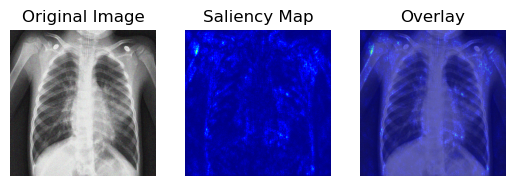

In [21]:
import torch
import torchvision.models as models
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the pre-trained VGG-19 model

network.eval()

# Freeze the parameters
for param in network.parameters():
    param.requires_grad = False

# Load the image
img = Image.open('027.jpeg')

# Preprocess the image
def preprocess(image):
    transform = T.Compose([
        T.Resize((512, 512)),  
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

def deprocess(image):
    transform = T.Compose([
        T.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        T.Lambda(lambda x: torch.clamp(x, 0, 1)),  # Clamp to valid range [0, 1]
        T.ToPILImage(),
    ])
    return transform(image)

X = preprocess(img) 

# Ensure both model and input image are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network.to(device)
X = X.to(device)
X.requires_grad_()

# Forward pass
scores = network(X)
score_max_index = scores.argmax()
score_max = scores[0, score_max_index]
score_max.backward()

saliency, _ = torch.max(X.grad.abs(), dim=1)

# Normalize the saliency map
saliency = saliency.squeeze().cpu().numpy()
saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

# Visualize the original image
plt.subplot(1, 3, 1)
plt.imshow(img.resize((512, 512)))
plt.title('Original Image')
plt.axis('off')

# Visualize the saliency map
plt.subplot(1, 3, 2)
plt.imshow(saliency, cmap=plt.cm.jet)
plt.title('Saliency Map')
plt.axis('off')

# Overlay the saliency map on the original image
plt.subplot(1, 3, 3)
plt.imshow(img.resize((512, 512)))
plt.imshow(saliency, cmap=plt.cm.jet, alpha=0.6)
plt.title('Overlay')
plt.axis('off')

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


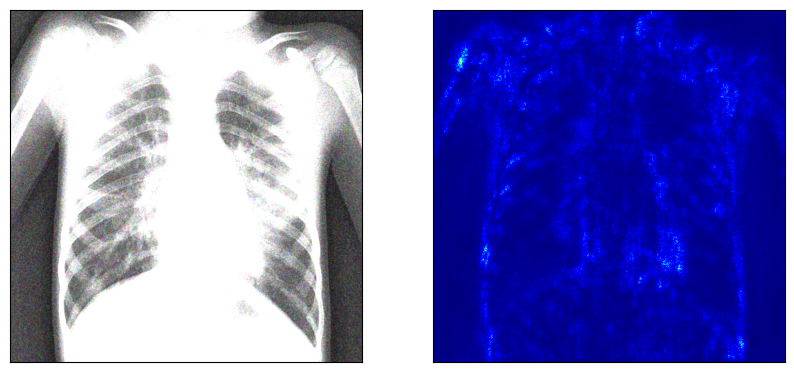

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import  torchvision.transforms as transforms

 #Define transforms for preprocessing input image into a format expected by the model
normalize = transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust normalization parameters for thermal images

# Inverse transform to get the normalized image back to its original form for visualization
inv_normalize = transforms.Normalize(mean=[-1], std=[1])

# Transforms to resize image to the size expected by the model, convert PIL image to tensor, and normalize the image
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    normalize,
])


def saliency(img, model):
    # Get the device of the model
    device = next(model.parameters()).device
    
    # Set the model to evaluation mode
    model.eval()
    
    # Transform input PIL image to torch.Tensor and normalize
    input = transform(img).to(device)  # Move input tensor to the same device as the model
    input.unsqueeze_(0)
    input.requires_grad = True
    
    # Forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    
    # Define a dummy loss (scalar) for gradient computation
    dummy_loss = score.sum()  # Summing up the scores to make it a scalar
    
    # Backward pass to get gradients of the dummy loss w.r.t. input image
    dummy_loss.backward()
    
    # Get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    # Normalize to [0..1]
    slc = (slc - slc.min()) / (slc.max() - slc.min())

    # Apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])

    # Plot image and its saliency map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))  # Move tensor to CPU for visualization
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.cpu().numpy(), cmap=plt.cm.jet)  # Move tensor to CPU for visualization
    plt.xticks([])
    plt.yticks([])
    plt.show()

img = Image.open('027.jpeg')
saliency(img, network)


In [ ]:
https://discuss.pytorch.org/t/understanding-transform-normalize/21730

https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

https://www.geeksforgeeks.org/python-loop-through-folders-and-files-in-directory/

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

https://imgaug.readthedocs.io/en/latest/source/overview/meta.html

https://github.com/sunnynevarekar/pytorch-saliency-maps/blob/master/Saliency_maps_in_pytorch.ipynb